In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu


## constants and functions

In [319]:

PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

PATH_TO_BC = '../data_in/black_carbon_channel6_masked_5min.csv'
# PATH_TO_BC = '../data_in/black_carbon_channel6_raw_5min.csv'

PATH_1000_CLUS = '../data_out/cluster1000.nc'

LA = 'lat'
LO = 'lon'
TI = 'time'
AG = 'age'
AT = 'AIRTRACER'
L = 'lab'
CM = 'tab20'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

BC = 'bc_masked_ngm3'

# BC = 'bc_raw_ngm3'

LBC = 'log(bc)'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

COLS = [SA, MSA, IA]
LCOLS = [LSA, LMSA, LIA]

DATA_OUT = '../data_out'

COL = plt.get_cmap('Dark2')

DC = {
    SA  : COL(0),
    MSA : COL(1),
    IA  : COL(2),
    LSA : COL(0),
    LMSA: COL(1),
    LIA : COL(2),
    BC  : COL(3),
    LBC : COL(3)
}

In [320]:
df = pd.read_csv(PATH_TO_BC, index_col=0, parse_dates=True)
(df[BC]>0).value_counts()

True     24908
False     5380
Name: bc_masked_ngm3, dtype: int64

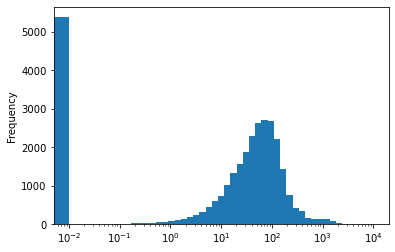

In [321]:
df[BC].plot.hist(bins=[df[BC].min()-1,*np.geomspace(.01,10000)])
plt.gca().set_xscale('log')

In [322]:
df=df[df[BC]>0]

(0.106457777576, 1981.9854372840073)

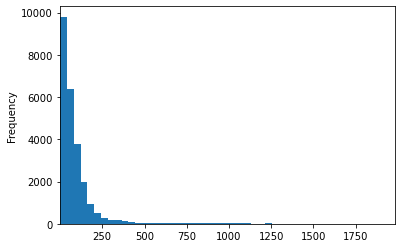

In [323]:
p = (df[BC]**1)
q1,q2 = p.quantile([.001,.999])
p.plot.hist(bins=np.linspace(q1,q2))
ax = plt.gca()
ax.set_xlim(q1,q2)

(0.5106607984983879, 9.752818343977255)

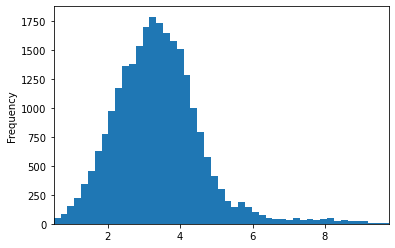

In [324]:
p = (df[BC]**.3)
q1,q2 = p.quantile([.001,.999])
p.plot.hist(bins=np.linspace(q1,q2))
ax = plt.gca()
ax.set_xlim(q1,q2)

In [325]:
df[LBC] = np.log10(df[BC])

# distributions


lets find what kind of dist. do we have. They seem to be log dists.

Text(0.5, 0, 'log10')

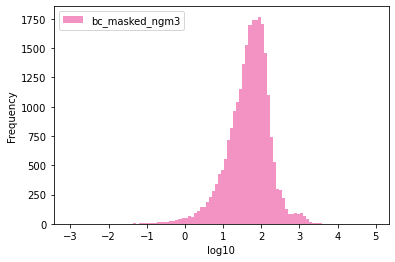

In [326]:
for c in [BC]:
    np.log10(df[c]).plot.hist(alpha=.5, bins=100, label=c, color=DC[c])
ax = plt.gca()
ax.legend()
ax.set_xlabel('log10')

# timeseries of the trace gases

# open and merge flex 1000 clusters

In [327]:
ds = xr.open_dataset(PATH_1000_CLUS)

In [328]:
dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

In [329]:
dsf.sum()

lab
0      117.893692
1      116.569145
2       99.189194
3       98.726097
4       90.979523
          ...    
995      0.544238
996      0.526847
997      0.512809
998      0.465698
999      0.453642
Length: 1000, dtype: float32

In [330]:
from sklearn.preprocessing import RobustScaler

In [331]:
RS = RobustScaler(
    with_centering=False,
    with_scaling=True,
    quantile_range=(25.0, 75.0),
    copy=True,
    unit_variance=False,
)

In [332]:
dsf2 = dsf/np.sqrt((dsf**2).sum())

In [333]:
dsf2.sum()

lab
0      15.317408
1      11.129049
2      10.441088
3      11.637880
4      14.796584
         ...    
995    30.548052
996    31.100914
997    30.608913
998    30.391745
999    32.368301
Length: 1000, dtype: float32

In [334]:
df1 = df[[BC]]

In [335]:
df2 = df1.resample('3H').median()
df3 = df2[~df2[BC].isna()]

In [336]:
dm = pd.merge(df3, dsf2, left_index=True, right_index=True, how='inner', validate="1:1")

# Linear Regression

In [337]:
from sklearn.linear_model import ElasticNetCV,ElasticNet, LinearRegression

In [338]:
lreg = LinearRegression(
    fit_intercept=False,
    normalize='deprecated',
    copy_X=True,
    n_jobs=None,
    positive=True,
)

In [339]:
X = dm[dsf2.columns]
y = dm[BC]
lreg.fit(X,y)
y_pred = lreg.predict(X)

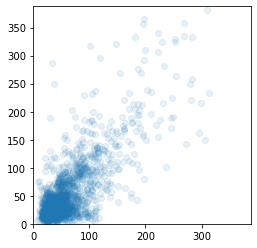

In [340]:
plt.scatter(y_pred,y,alpha=.1)
ax=plt.gca()
ax.set_xlim(0,y.quantile(.99))
ax.set_ylim(0,y.quantile(.99))
ax.set_aspect('equal')

<AxesSubplot:xlabel='time'>

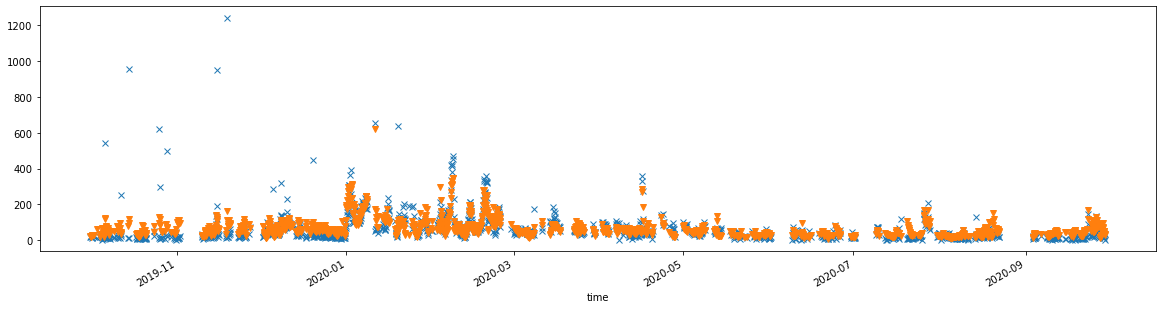

In [341]:
f,ax = plt.subplots(figsize=(20,5))
y.plot(lw=0,marker='x')
(y*0 + y_pred).plot(lw=0,marker='v')

In [342]:
tot_sd = (y**2).sum()**.5

In [343]:
exp_sd = ((y-y_pred)**2).sum()**.5

In [344]:
best_sd = exp_sd/tot_sd
best_sd

0.6023679765470931

In [345]:
np.corrcoef(y,y_pred)[0,1]**2

0.4383395496171839

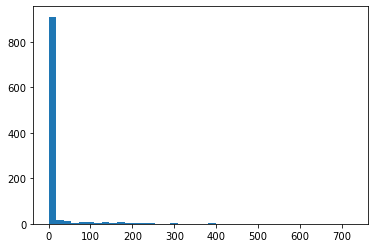

In [346]:
plt.hist(lreg.coef_,bins=40);

# Elastic net regression cross validated

$L_{\text {enet }}(\hat{\beta})=\frac{\sum_{i=1}^{n}\left(y_{i}-x_{i}^{\prime} \hat{\beta}\right)^{2}}{2 n}+\lambda\left(\frac{1-\alpha}{2} \sum_{j=1}^{m} \hat{\beta}_{j}^{2}+\alpha \sum_{j=1}^{m}\left|\hat{\beta}_{j}\right|\right)$

In [347]:
e_reg_cv=ElasticNetCV(
    l1_ratio=[.1,0.5,0.7,.9,.99,.999,.9999,.99999,.999999,.9999999],
    eps=0.001,
    n_alphas=100,
    alphas=None,
    fit_intercept=False,
    normalize='deprecated',
    precompute='auto',
    max_iter=1000,
    tol=0.0001,
    cv=5,
    copy_X=True,
    verbose=0,
    n_jobs=None,
    positive=True,
    random_state=None,
    selection='cyclic',
)

In [348]:
X = dm[dsf2.columns]
y = dm[BC]
e_reg_cv.fit(X,y)
y_pred = e_reg_cv.predict(X)

In [349]:
exp_sd = ((y-y_pred)**2).sum()**.5

In [350]:
exp_sd/tot_sd

0.6429797961225733

In [351]:
cv_a = e_reg_cv.alpha_
cv_a

0.0028006589273022933

In [352]:
cv_l1 = e_reg_cv.l1_ratio_
cv_l1

0.5

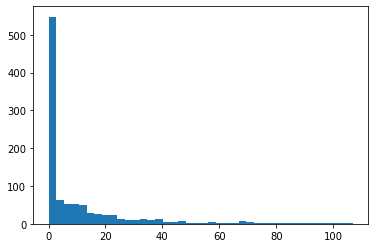

In [353]:
plt.hist(e_reg_cv.coef_,bins=40);

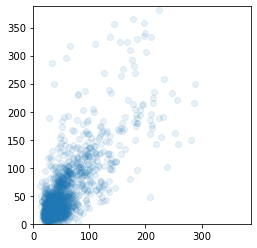

In [354]:
plt.scatter(y_pred,y,alpha=.1)
ax=plt.gca()
ax.set_xlim(0,y.quantile(.99))
ax.set_ylim(0,y.quantile(.99))
ax.set_aspect('equal')

<AxesSubplot:xlabel='time'>

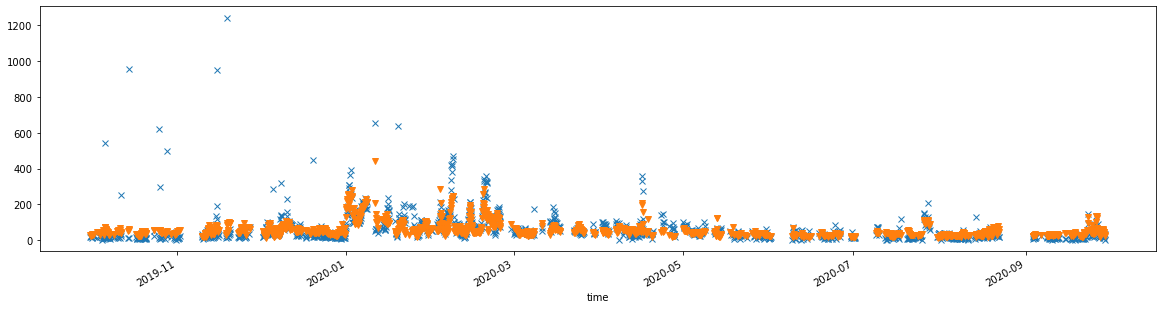

In [355]:
f,ax = plt.subplots(figsize=(20,5))
y.plot(lw=0,marker='x')
(y*0 + y_pred).plot(lw=0,marker='v')

alpha = a + b and l1_ratio = a / (a + b)

In [356]:
cv_a

0.0028006589273022933

In [357]:
B = cv_a * (1-cv_l1)
B

0.0014003294636511466

In [358]:
A = cv_a - B
A

0.0014003294636511466

# selection

In [359]:
def elastic_net(_a, _l1, dsf2, dm, BC,tot_sd):
    e_reg = ElasticNet(
        alpha=_a,
        l1_ratio=_l1,
        fit_intercept=False,
        normalize='deprecated',
        precompute=False,
        max_iter=1000,
        copy_X=True,
        tol=0.0001,
        warm_start=False,
        positive=True,
        random_state=None,
        selection='cyclic',
    )

    X = dm[dsf2.columns]
    y = dm[BC]
    e_reg.fit(X, y)
    y_pred = e_reg.predict(X)



    exp_sd = ((y - y_pred) ** 2).sum() ** .5

    ratio = exp_sd / tot_sd

    coef = X.sum().T * 0 + e_reg.coef_
    return coef, ratio, exp_sd

In [360]:
def to_min(fac):
    nA = fac*A

    _a = B + nA 

    _l1 = nA/(nA + B)


    coef, ratio, exp_sd = elastic_net(_a, _l1, dsf2, dm, BC,tot_sd)
#     print(ratio)
    return np.abs(ratio - .9999)

In [361]:
from scipy.optimize import minimize_scalar

In [362]:
res = minimize_scalar(to_min,method='Bounded',bounds=(1,1000))

In [427]:
aas = np.linspace(1,res.x,100)

In [428]:
aas

array([  1.        ,  11.07978847,  21.15957694,  31.23936542,
        41.31915389,  51.39894236,  61.47873083,  71.5585193 ,
        81.63830778,  91.71809625, 101.79788472, 111.87767319,
       121.95746166, 132.03725014, 142.11703861, 152.19682708,
       162.27661555, 172.35640402, 182.4361925 , 192.51598097,
       202.59576944, 212.67555791, 222.75534638, 232.83513486,
       242.91492333, 252.9947118 , 263.07450027, 273.15428874,
       283.23407721, 293.31386569, 303.39365416, 313.47344263,
       323.5532311 , 333.63301957, 343.71280805, 353.79259652,
       363.87238499, 373.95217346, 384.03196193, 394.11175041,
       404.19153888, 414.27132735, 424.35111582, 434.43090429,
       444.51069277, 454.59048124, 464.67026971, 474.75005818,
       484.82984665, 494.90963513, 504.9894236 , 515.06921207,
       525.14900054, 535.22878901, 545.30857749, 555.38836596,
       565.46815443, 575.5479429 , 585.62773137, 595.70751985,
       605.78730832, 615.86709679, 625.94688526, 636.02

In [429]:
dic = {}
for aa in aas:
#     print(aa)
    d2 = {}
    nA = aa * A
#     print(aa)

    _a = B + nA 

    _l1 = nA/(nA + B)


    coef, ratio, exp_sd = elastic_net(_a, _l1, dsf2, dm, BC,tot_sd)

    inn=coef[coef>0].index


    e_reg_cv=ElasticNetCV(
        l1_ratio=0.01,
        eps=0.001,
    #     n_alphas=100,
        alphas=[.0001,.001,.01,.1,1,10,100,1000,10000],
        fit_intercept=False,
        normalize='deprecated',
        precompute='auto',
        max_iter=100000,
        tol=0.0001,
        cv=5,
        copy_X=True,
        verbose=0,
        n_jobs=None,
        positive=True,
        random_state=None,
        selection='cyclic',
    )

    X = dm[inn]
    y = dm[BC]
    e_reg_cv.fit(X, y)
    y_pred = e_reg_cv.predict(X)

    exp_sd = ((y - y_pred) ** 2).sum() ** .5

    ratio = exp_sd / tot_sd

    coef = X.sum().T * 0 + e_reg_cv.coef_

    d2['coef'] = coef
    d2['ratio'] = ratio
    d2['exp_sd'] = exp_sd
    dic[aa] = d2
        


/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149456.75, tolerance: 1029.4940185546875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142833.390625, tolerance: 964.8446044921875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349849.65625, tolerance: 1265.88232421875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packa

In [398]:
dk = {}
for k,r in dic.items():
    dk[k] = r['coef'].to_dict()
ddf = pd.DataFrame(dk).T

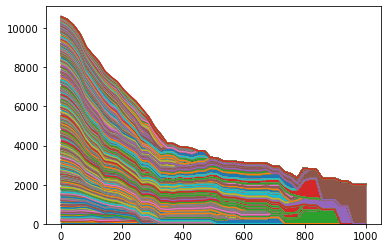

In [399]:

ddf.plot.area()
ax = plt.gca()
ax.get_legend().remove()

<AxesSubplot:>

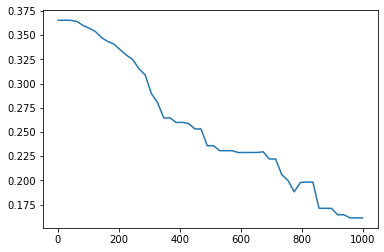

In [400]:
dk = {}
for k,r in dic.items():
    dk[k] = 1-r['ratio']
pd.Series(dk).plot()

In [408]:
dk = {}
for k,r in dic.items():
    dk[1-dic[k]['ratio']] = r['coef'].to_dict()
ddf = pd.DataFrame(dk).T

In [659]:
la = []
rr = []
# lr = {0.1+i/100000:0 for i in range(1,100)}
lr = {0:0}
# lr = {}
for l,r in ddf[::-1].iterrows():
    ii = r[r>0].index
    bo = ~ii.isin(la)
    la = [*la,*list(ii[bo])]
    rr = [*rr,*r[list(ii[bo])].values]
    lr[len(la)] = l
    
    

In [660]:
n_sd = pd.Series(lr)

In [716]:
from pygam import LinearGAM, s

# X = np.log10(n_sd.reset_index()[['index']])
X = (n_sd.reset_index()[['index']])
y = n_sd

gam1 = LinearGAM(s(0, constraints='concave',n_splines=20,spline_order=3)).fit(X, y)
# gam1 = LinearGAM(s(0,n_splines=20,spline_order=3)).fit(X, y)

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/pygam/pygam.py:752: RuntimeWarning: divide by zero encountered in reciprocal
  np.fill_diagonal(Dinv, d**-1) # invert the singular values


In [717]:
X1=10**X
X1=X

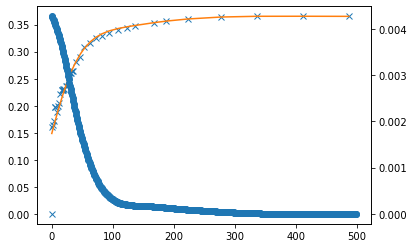

In [738]:
f,ax = plt.subplots()
ax.plot(X1,n_sd,lw=0,marker='x')
ax.plot(X1,gam1.predict(X))

def ffit(x): 
#     if x ==0:
#         return 0
#     else:
#         return gam1.predict([x])[0]
    return gam1.predict([x])[0]

from scipy.misc import derivative

x = np.arange(0,500,1)

y = [derivative(ffit,_) for _ in x ]

axx = ax.twinx()
axx.plot(x,y,lw=1,marker='o')
# axx.set_yscale('log')

In [739]:
ni = pd.Series(rr,index=la)

In [740]:
ni1 = ni[::-1].reset_index().reset_index().set_index('index')['level_0'].to_dict()
ni1 = ni[::].reset_index().reset_index().set_index('index')['level_0'].to_dict()

In [753]:
ni2 = {i:derivative(ffit,_)  for i,_ in ni1.items()}
ni2 = {i:ffit(_)  for i,_ in ni1.items()}

In [754]:
_ds = ds['lab'].to_series()

In [755]:
_ds1 = _ds.where(_ds.isin(ni2)).replace(ni2).to_xarray()

In [756]:
_ds1

<xarray.DataArray 'lab' (lat: 24, lon: 72)>
array([[0.3654394 , 0.35981528, 0.2521381 , ..., 0.36545234, 0.36543273,
        0.36526834],
       [0.3654394 , 0.35981528, 0.27559863, ..., 0.36545234, 0.36531491,
        0.36526834],
       [0.36543049, 0.3654416 , 0.34257128, ...,        nan, 0.36531491,
        0.36527351],
       ...,
       [0.36432702, 0.36537193, 0.36542101, ..., 0.36543197, 0.36432702,
        0.36432702],
       [0.36540885, 0.36540885, 0.36540885, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float64 60.62 61.88 63.12 64.38 ... 85.62 86.88 88.12 89.38
  * lon      (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5

In [757]:
# plt.scatter(y_pred,y,alpha=.1)
# ax=plt.gca()
# ax.set_xlim(0,y.quantile(.99))
# ax.set_ylim(0,y.quantile(.99))
# ax.set_aspect('equal')

In [758]:
# f,ax = plt.subplots(figsize=(20,5))
# y.plot(lw=0,marker='x')
# (y*0 + y_pred).plot(lw=0,marker='v')

In [759]:
_ds2 = (_ds1/_ds1.max())**10
_ds2 = _ds1/_ds1.max()
_ds2 = _ds1

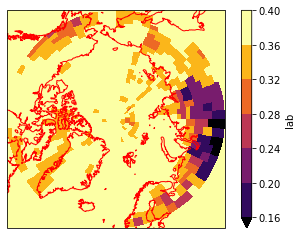

In [763]:
# inn = coef[coef>0].index

# pl = ds['lab'].where(ds['lab'].isin(inn))* 0 + 1




import cartopy.crs as ccrs
ax = plt.subplot(projection=ccrs.Orthographic(0, 90), facecolor=plt.get_cmap('inferno_r')(0))
(_ds2).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    robust=True,
    levels=6,
    cmap='inferno',
#     vmin=0,

)
ax.coastlines(color='red')

In [762]:
ds

<xarray.Dataset>
Dimensions:    (lon: 72, lat: 24, time: 3021)
Coordinates:
  * lon        (lon) float64 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * lat        (lat) float64 60.62 61.88 63.12 64.38 ... 85.62 86.88 88.12 89.38
  * time       (time) datetime64[ns] 2019-09-20T09:00:00 ... 2020-10-01T21:00:00
    lab        (lat, lon) int64 837 917 976 831 825 815 ... 463 294 294 294 294
Data variables:
    AIRTRACER  (time, lat, lon) float32 0.0004269 0.0001852 ... 0.0002132